## Project overview
1. [EDA](#eda)
    - [Ratings](#ratings)
    - [Tags](#tags)
    - [Movies](#movies)
    - [Merged data](#merged)
2. [Feature engineering](#fe)
4. [User clustering](#clusters)
3. [Merge data and check the features](#merge)
4. [Initial feature importances](#importance)
    - [Linear Regression](#linreg)
    - [Decision Tree Regressor](#tree)
5. [Modeling](#models)


NB: This nav is kinda broken in Github but it is ok when you download the notebook

In [1]:
import warnings

warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
np.random.seed(3104)

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import matplotlib as mlp

mlp.rcParams['lines.linewidth'] = 5

mlp.rcParams['xtick.major.size'] = 15
mlp.rcParams['xtick.major.width'] = 2
mlp.rcParams['xtick.labelsize'] = 15
mlp.rcParams['xtick.color'] = '#4DFC2D'

mlp.rcParams['ytick.major.size'] = 15
mlp.rcParams['ytick.major.width'] = 2
mlp.rcParams['ytick.labelsize'] = 15
mlp.rcParams['ytick.color'] = '#4DFC2D'

mlp.rcParams['axes.labelsize'] = 20
mlp.rcParams['axes.titlesize'] = 20
mlp.rcParams['axes.titlecolor'] = '#ED6919'
mlp.rcParams['axes.labelcolor'] = '#ED6919'

mlp.rcParams['figure.figsize'] = (10, 6)

In [4]:
ratings = pd.read_csv('ratings.csv', sep=',').head(1000000)

ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [5]:
tags = pd.read_csv('tags.csv').drop('timestamp', axis=1)

tags.head()

,userId,movieId,tag
0,18,4141,Mark Waters
1,65,208,dark hero
2,65,353,dark hero
3,65,521,noir thriller
4,65,592,dark hero


In [6]:
movies = pd.read_csv('movies.csv')

movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


<a id='eda'></a>
### Exploratory data analysis 

<a id='ratings'></a>

#### Ratings

In [7]:
ratings.timestamp = pd.to_datetime(ratings.timestamp, unit='s')

In [8]:
ratings.isna().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

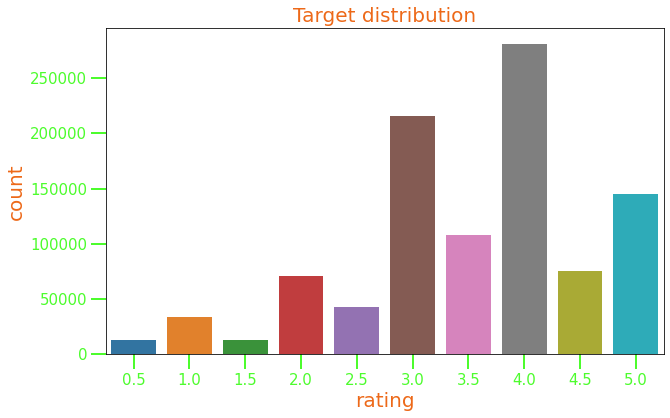

In [9]:
sns.countplot(ratings.rating)

plt.title('Target distribution')
plt.show()

<a id='tags'></a>

#### Tags

In [10]:
tags.isna().sum()

userId      0
movieId     0
tag        16
dtype: int64

In [11]:
tags[tags.tag.isna()].userId.value_counts()

116460    15
133634     1
Name: userId, dtype: int64

In [12]:
tags = tags.dropna()

<a id='movies'></a>

#### Movies

In [13]:
movies.isna().any()

movieId    False
title      False
genres     False
dtype: bool

<a id='fe'></a>

#### Feature engineering

Add **mean rating**, **total views** and **views per day** for each user

In [14]:
ratings['mean_user_rating'] = ratings.userId.map(
    ratings.groupby('userId').rating.mean()
)

In [15]:
ratings.head()

,userId,movieId,rating,timestamp,mean_user_rating
0,1,2,3.5,2005-04-02 23:53:47,3.742857
1,1,29,3.5,2005-04-02 23:31:16,3.742857
2,1,32,3.5,2005-04-02 23:33:39,3.742857
3,1,47,3.5,2005-04-02 23:32:07,3.742857
4,1,50,3.5,2005-04-02 23:29:40,3.742857


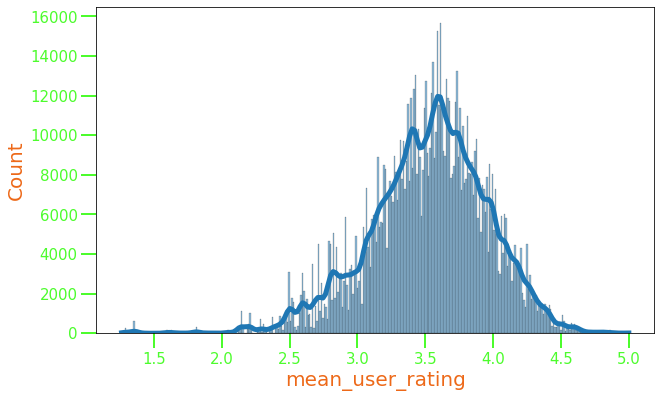

In [16]:
sns.histplot(ratings.mean_user_rating, kde=True)

plt.show()

In [17]:
total_views = ratings.groupby('userId').movieId.count()
ratings['total_views'] = ratings.userId.map(total_views) 

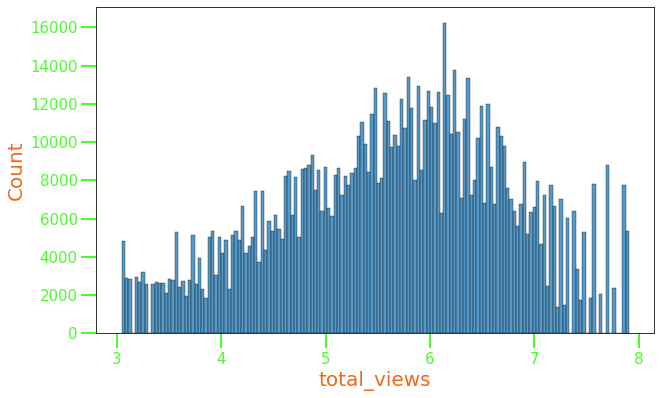

In [18]:
sns.histplot(np.log1p(ratings.total_views))

plt.show()

In [21]:
ratings['first_view'] = ratings.userId.map(ratings.groupby('userId').timestamp.min())
ratings['last_view'] = ratings.userId.map(ratings.groupby('userId').timestamp.max())

ratings['total_days'] = (ratings.last_view - ratings.first_view).dt.days

ratings.head()

,userId,movieId,rating,timestamp,mean_user_rating,total_views,first_view,last_view,total_days
0,1,2,3.5,2005-04-02 23:53:47,3.742857,175,2004-09-10 03:06:38,2005-04-02 23:56:41,204
1,1,29,3.5,2005-04-02 23:31:16,3.742857,175,2004-09-10 03:06:38,2005-04-02 23:56:41,204
2,1,32,3.5,2005-04-02 23:33:39,3.742857,175,2004-09-10 03:06:38,2005-04-02 23:56:41,204
3,1,47,3.5,2005-04-02 23:32:07,3.742857,175,2004-09-10 03:06:38,2005-04-02 23:56:41,204
4,1,50,3.5,2005-04-02 23:29:40,3.742857,175,2004-09-10 03:06:38,2005-04-02 23:56:41,204


In [22]:
ratings['views_per_day'] = ratings.total_views / (ratings.total_days + 1)

ratings.head()

,userId,movieId,rating,timestamp,mean_user_rating,total_views,first_view,last_view,total_days,views_per_day
0,1,2,3.5,2005-04-02 23:53:47,3.742857,175,2004-09-10 03:06:38,2005-04-02 23:56:41,204,0.853659
1,1,29,3.5,2005-04-02 23:31:16,3.742857,175,2004-09-10 03:06:38,2005-04-02 23:56:41,204,0.853659
2,1,32,3.5,2005-04-02 23:33:39,3.742857,175,2004-09-10 03:06:38,2005-04-02 23:56:41,204,0.853659
3,1,47,3.5,2005-04-02 23:32:07,3.742857,175,2004-09-10 03:06:38,2005-04-02 23:56:41,204,0.853659
4,1,50,3.5,2005-04-02 23:29:40,3.742857,175,2004-09-10 03:06:38,2005-04-02 23:56:41,204,0.853659


In [26]:
ratings['year'] = ratings.timestamp.dt.year
ratings['month'] = ratings.timestamp.dt.month
ratings['weekday'] = ratings.timestamp.dt.weekday
ratings['hour'] = ratings.timestamp.dt.hour
ratings = ratings.sort_values(by='timestamp')

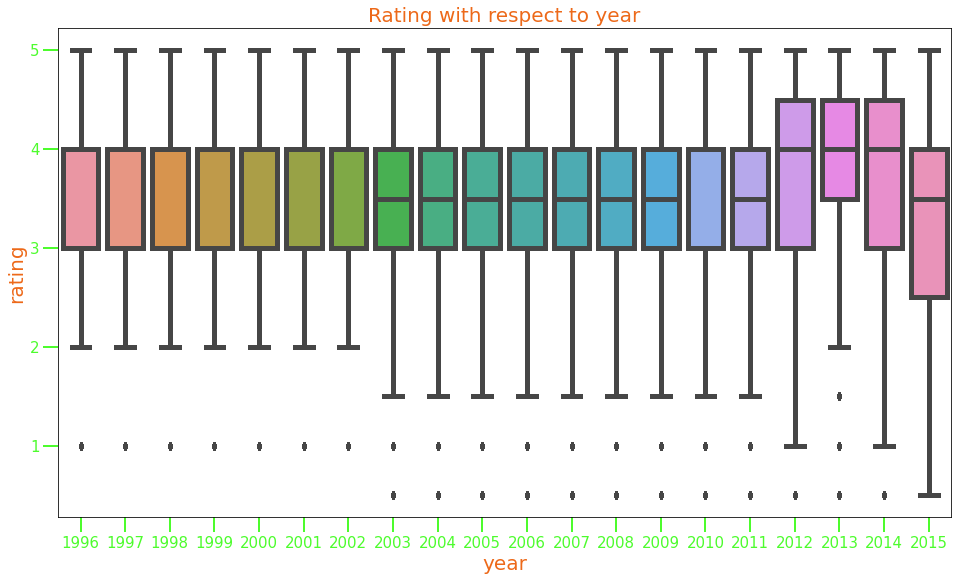

In [27]:
plt.figure(figsize=(16, 9))

sns.boxplot(x=ratings.year, y=ratings.rating)

plt.title('Rating with respect to year')
plt.xticks()
plt.show()

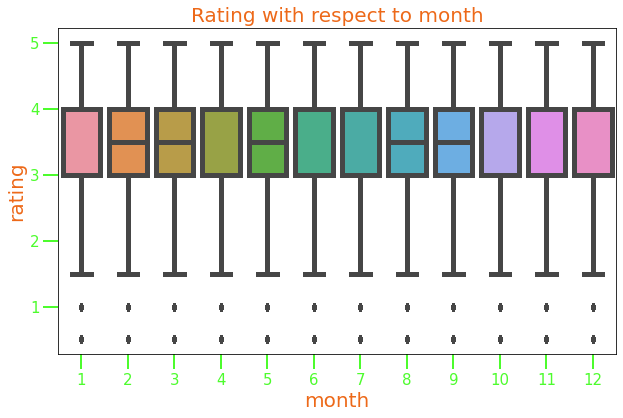

In [28]:
plt.figure(figsize=(10, 6))

sns.boxplot(x=ratings.month, y=ratings.rating)

plt.title('Rating with respect to month')
plt.xticks()
plt.show()

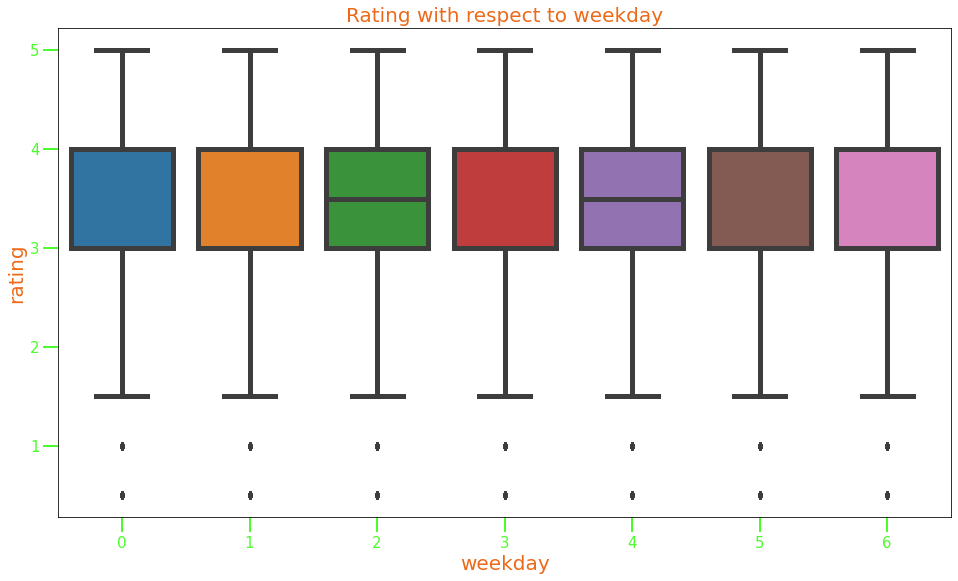

In [29]:
plt.figure(figsize=(16, 9))

sns.boxplot(x=ratings.weekday, y=ratings.rating)

plt.title('Rating with respect to weekday')
plt.xticks()
plt.show()

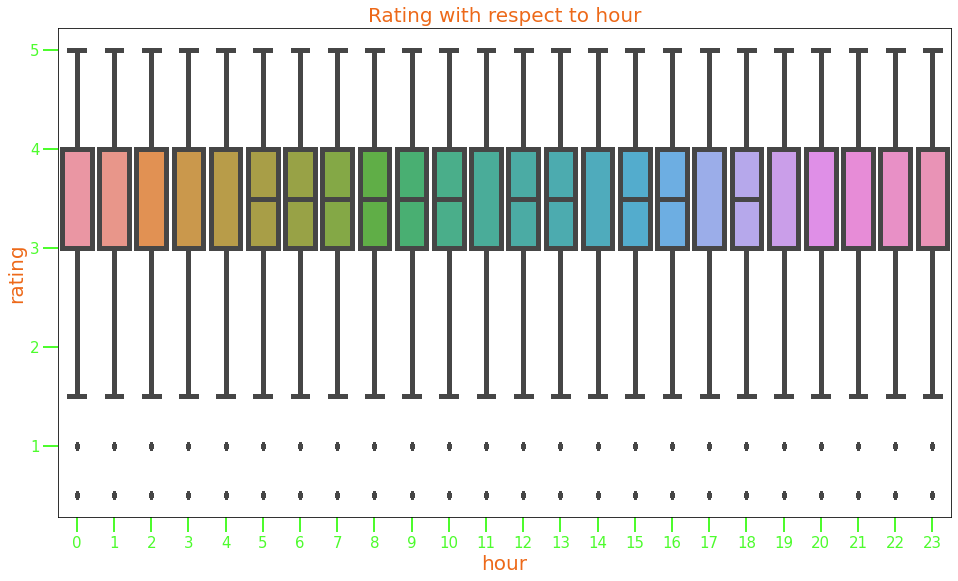

In [30]:
plt.figure(figsize=(16, 9))

sns.boxplot(x=ratings.hour, y=ratings.rating)

plt.title('Rating with respect to hour')
plt.xticks()
plt.show()

Ratings do not differ for different **month**, **weekday** and **hour**, so we will drop these columns

**Year** has some minor differences, so we may try to use it via `year_parse()`

In [31]:
def year_parse(year):
    if year < 2003:
        return 'old_rating'
    elif year <= 2011:
        return 'middle_rating'
    else:
        return 'new_rating'

In [32]:
ratings.year = ratings.year.apply(year_parse)
ratings = ratings.drop(['month', 'weekday', 'hour'], axis=1)

In [33]:
ratings.head()

,userId,movieId,rating,timestamp,mean_user_rating,total_views,total_days,views_per_day,year
729444,4864,79,1.0,1996-02-28 09:32:14,3.689655,261,390,0.667519,old_rating
729429,4864,17,5.0,1996-02-28 09:32:14,3.689655,261,390,0.667519,old_rating
729426,4864,10,3.0,1996-02-28 09:32:14,3.689655,261,390,0.667519,old_rating
729427,4864,11,5.0,1996-02-28 09:32:14,3.689655,261,390,0.667519,old_rating
729445,4864,92,2.0,1996-02-28 09:32:15,3.689655,261,390,0.667519,old_rating


In [34]:
tags.tag.nunique()

38643

Add tag frequencies

In [35]:
tags['tag_count'] = tags.tag.map(
    tags.tag.value_counts()
)

tags.head()

,userId,movieId,tag,tag_count
0,18,4141,Mark Waters,10
1,65,208,dark hero,194
2,65,353,dark hero,194
3,65,521,noir thriller,327
4,65,592,dark hero,194


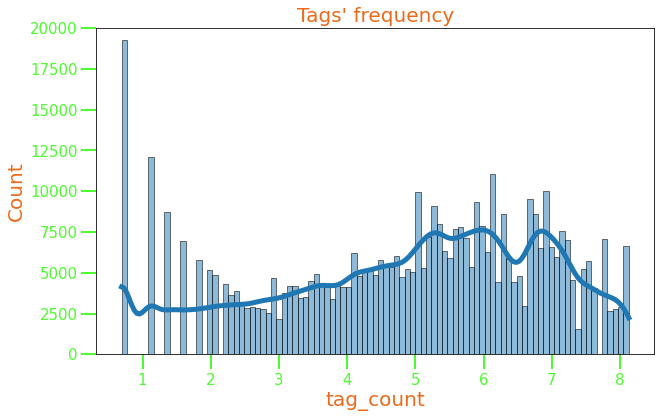

In [36]:
sns.histplot(np.log1p(tags.tag_count), kde=True)

plt.title("Tags' frequency")
plt.ylim(0, 20000)
plt.show()

In [37]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Get movie release dates

In [38]:
import re

def title_feature_extraction(title):
    m = re.search(r"\(([0-9_]+)\)", title)
    return None if m is None else m.group(1)

In [39]:
movies['movie_year'] = movies.title \
                        .apply(title_feature_extraction) \
                        .apply(lambda x: None if x is None or int(x) < 1888 else int(x))

movies.isna().sum()

movieId        0
title          0
genres         0
movie_year    25
dtype: int64

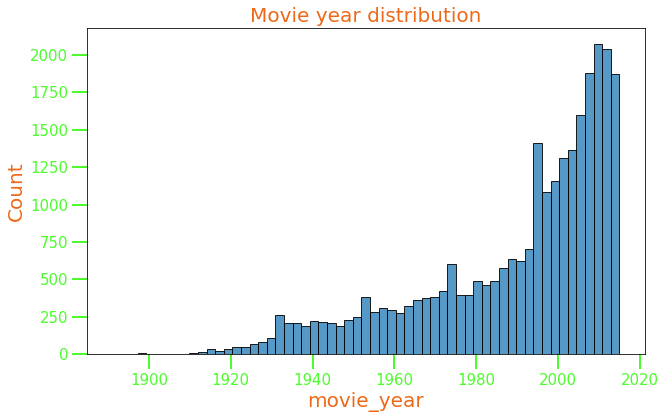

In [40]:
sns.histplot(movies.movie_year)

plt.title('Movie year distribution')
plt.show()

In [41]:
movies.movie_year = movies.movie_year.fillna(
    movies.movie_year.value_counts().index[0]
)

In [42]:
# drop_first to fix multicollinearity
genres = movies.genres.str.get_dummies(sep='|').drop('(no genres listed)', axis=1)

genres.head()

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [43]:
movies = pd.concat(
    (movies, genres),
    axis=1
)

In [44]:
movies.isna().sum().sum()

0

In [45]:
movies.title = movies.title.apply(
    lambda x:
        x.split('(')[0]
)

movies.head()

,movieId,title,genres,movie_year,Action,Adventure,Animation,Children,Comedy,Crime,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995.0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji,Adventure|Children|Fantasy,1995.0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men,Comedy|Romance,1995.0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995.0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II,Comedy,1995.0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


Using *TF-IDF* to extract features from the movie titles

In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf = TfidfVectorizer(token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b', stop_words='english')

df = pd.DataFrame(tf.fit_transform(movies.title).todense())
df.columns = tf.get_feature_names()

df.sample(5)

,10th,110th,11th,12th,13b,13hrs,13th,14th,19th,1st,...,école,époque,équipe,état,étoile,étudiante,öga,último,üvegtigris,貞子3d
1131,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23389,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20115,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7282,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3362,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
movies['movie_tf_idf_mean'] = df.mean(axis=1)

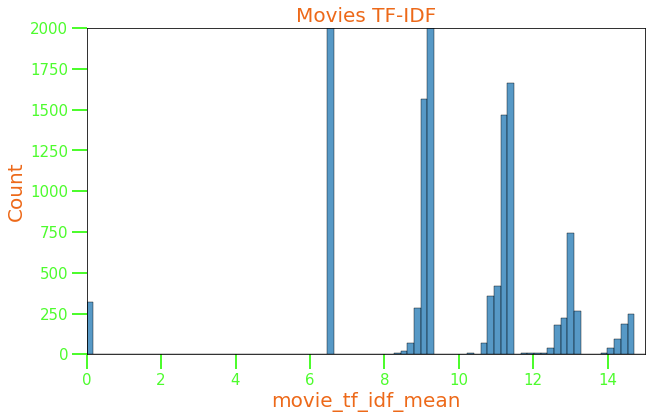

In [48]:
sns.histplot(movies.movie_tf_idf_mean * 1e5)

plt.xlim(0, 15)
plt.ylim(0, 2000)
plt.title('Movies TF-IDF')
plt.show()

In [49]:
movies = movies.drop(['title', 'genres'], axis=1)

movies.head()

,movieId,movie_year,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,movie_tf_idf_mean
0,1,1995.0,0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000091
1,2,1995.0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000066
2,3,1995.0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0.000111
3,4,1995.0,0,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0.000092
4,5,1995.0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000113


<a id='clusters'></a>
### User clustering

In [ ]:
users = ratings[
    ['userId', 'mean_user_rating', 'total_views', 'total_days', 'views_per_day']
].copy()
ratings = ratings.drop(['first_view', 'last_view'], axis=1)

In [24]:
users = users.drop_duplicates()
users.head()

,userId,mean_user_rating,total_views,total_days,views_per_day
0,1,3.742857,175,204,0.853659
175,2,4.000000,61,0,61.000000
236,3,4.122995,187,3,46.750000
423,4,3.571429,28,0,28.000000
451,5,4.272727,66,1,33.000000


In [56]:
from sklearn.manifold import TSNE

X_users = users.drop('userId', axis=1)
X_tsne = TSNE(n_components=2).fit_transform(X_users)

X_tsne

array([[-2.6335865e+01, -2.2766790e+00],
       [-4.4379360e+01,  3.3636745e+01],
       [-3.9992023e+01, -2.6977251e+01],
       ...,
       [-6.5828896e+01,  5.3547561e-02],
       [-1.7767567e+01,  3.0925938e+01],
       [-3.8703960e+01, -2.7846708e+01]], dtype=float32)

In [59]:
X_tsne = pd.DataFrame(X_tsne, columns=['component_1', 'component_2'])

X_tsne.head()

,component_1,component_2
0,-26.335865,-2.276679
1,-44.379360,33.636745
2,-39.992023,-26.977251
3,-23.336338,-71.576904
4,-69.352028,-1.631424


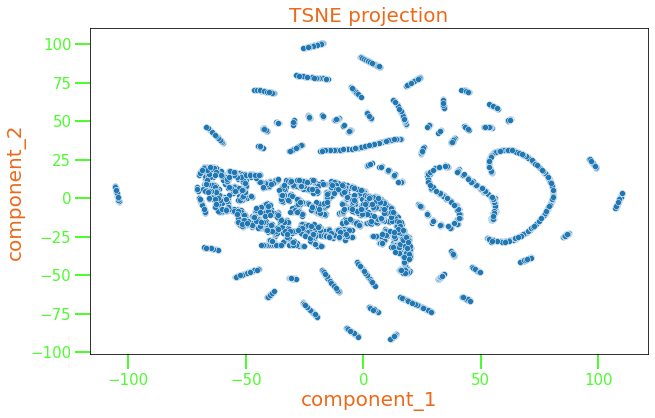

In [69]:
sns.scatterplot(x='component_1', y='component_2', data=X_tsne)

plt.title('TSNE projection')
plt.show()

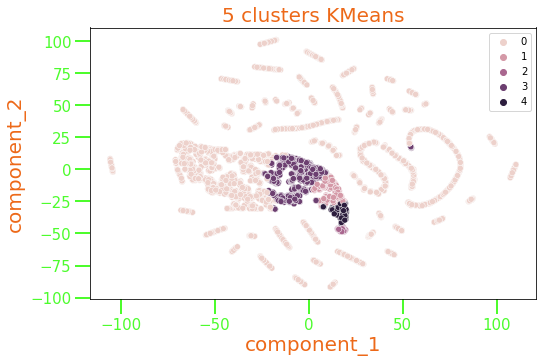

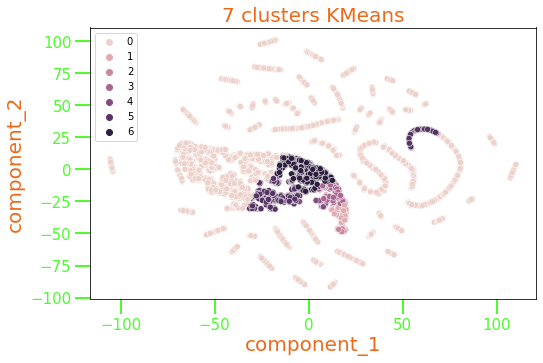

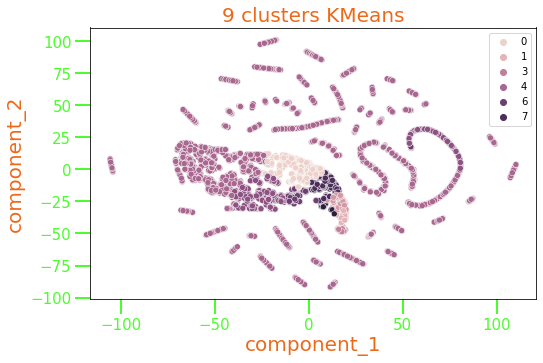

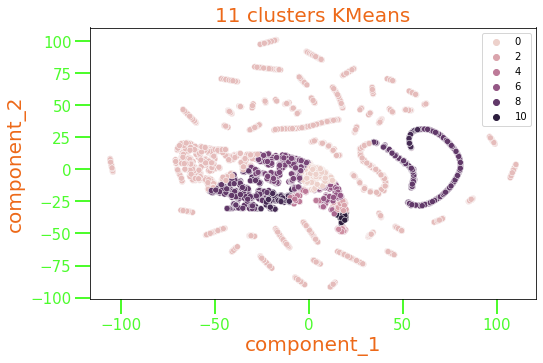

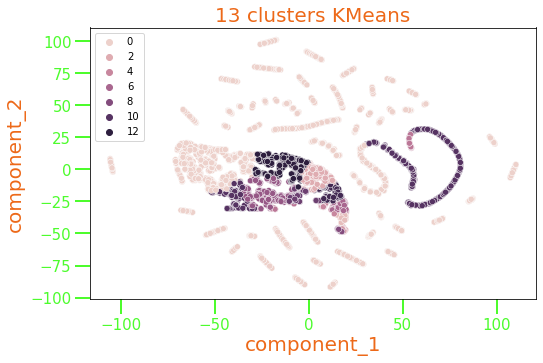

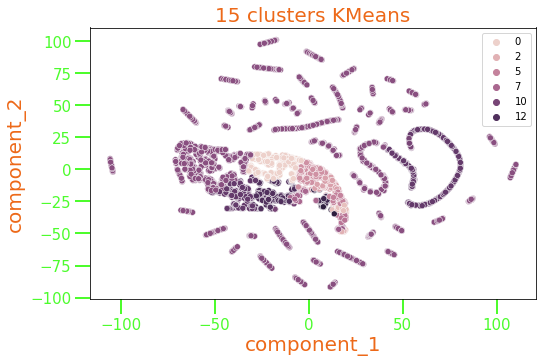

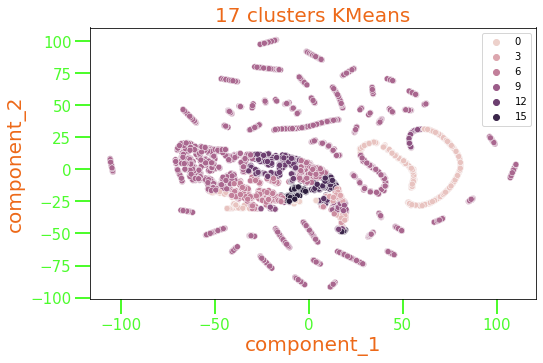

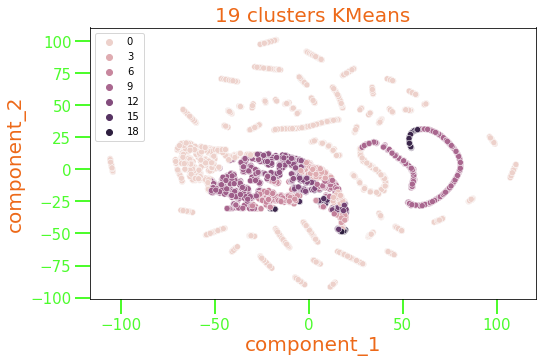

In [218]:
from sklearn.cluster import KMeans

for n_clusters in np.arange(5, 20, 2):
    segments = KMeans(n_clusters=n_clusters).fit_predict(X_users)

    plt.figure(figsize=(8, 5))
    sns.scatterplot(x='component_1', y='component_2', hue=segments, data=X_tsne)
    plt.title(f'{n_clusters} clusters KMeans')
    plt.show()

**KMeans** algorithm performs poorly, so we may try to use **DBSCAN** with some hyperparameter tuning

In [209]:
from sklearn.preprocessing import StandardScaler

X_scaled = StandardScaler().fit_transform(X_tsne)

X_scaled = pd.DataFrame(X_scaled, columns=['component_1', 'component_2'])

Finding the best hyperparameters for DBSCAN

In [222]:
X_scaled = X_scaled.sort_values(by=['component_1', 'component_2'])
df = pd.DataFrame(columns=['index', 'distance'])
for i in range(0, X_scaled.shape[0] - 1):
    dist = np.linalg.norm(X_scaled.iloc[i] - X_scaled.iloc[i + 1])
    df = df.append({'index': i, 'distance': dist}, ignore_index=True)
    
df = df.sort_values(by='distance')

In [225]:
df

,index,distance
2306,2306.0,0.0
3269,3269.0,0.0
1064,1064.0,0.0
3274,3274.0,0.0
1983,1983.0,0.0
...,...,...
2066,2066.0,4.33596
2283,2283.0,4.490328
2285,2285.0,4.492974
2340,2340.0,4.531408


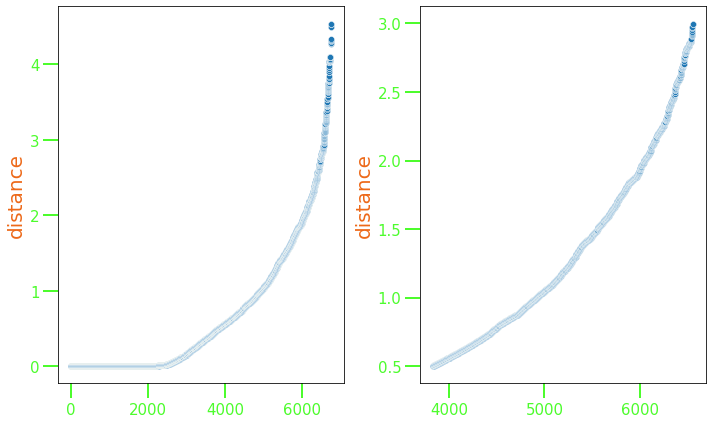

In [244]:
fig = plt.figure()
df.index = df.index.sort_values()

ax1 = fig.add_subplot(1, 2, 1)
sns.scatterplot(x=df.index, y=df.distance)


df_2 = df[(df.distance > 0.5) & (df.distance < 3)]

ax2 = fig.add_subplot(1, 2, 2)
sns.scatterplot(x=df_2.index, y=df_2.distance)

fig.tight_layout()
plt.show()

In [265]:
DBSCAN(eps=0.1).fit(X_scaled).labels_

array([ 0,  0,  0, ..., 56, 56, 56])

In [312]:
from sklearn.metrics import silhouette_score

epsilons = np.linspace(0.4, 0.55, 50)

max_score = -float('inf')
best_eps = 0

for eps in epsilons:
    db = DBSCAN(eps=eps, min_samples=100).fit(X_scaled)
    core_sample_masks = np.zeros_like(db.labels_, dtype=bool)
    core_sample_masks[db.core_sample_indices_] = True
    
    labels = db.labels_
    if len(set(labels)) >= 2:
        new_score = silhouette_score(X_scaled, labels)
        if max_score < new_score:
            max_score = new_score
            best_eps = eps
            print(set(labels), silhouette_score(X_scaled, labels), eps)

{0, 1, -1} 0.16003631 0.4
{0, 1, -1} 0.16394252 0.4030612244897959
{0, -1} 0.3075628 0.4061224489795919
{0, -1} 0.31559393 0.4091836734693878
{0, -1} 0.31602326 0.43367346938775514
{0, -1} 0.3173196 0.43673469387755104
{0, -1} 0.3177537 0.439795918367347
{0, -1} 0.31818628 0.4459183673469388
{0, -1} 0.31851146 0.45510204081632655
{0, -1} 0.31894365 0.4581632653061225
{0, -1} 0.31937614 0.4612244897959184
{0, -1} 0.33266652 0.476530612244898
{0, -1} 0.33341557 0.4979591836734694
{0, -1} 0.34375948 0.5010204081632653


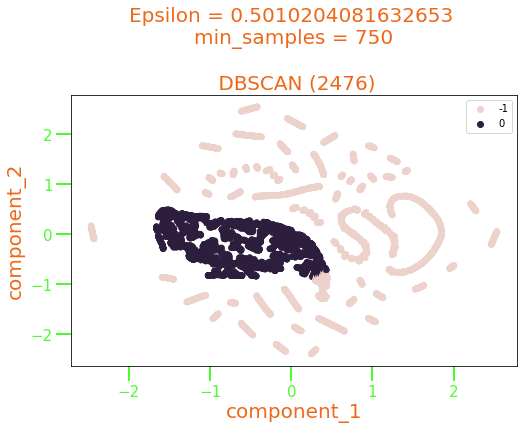

In [323]:
from itertools import product
from sklearn.cluster import DBSCAN

# epsilons = np.arange(0.1, 5, 10)
epsilons = [0.5010204081632653]
samples = [740, 750]

for eps, neighbours in product(epsilons, samples):
    
    dbscan = DBSCAN(eps=eps, min_samples=neighbours).fit(X_scaled)
    y = dbscan.labels_

    plt.figure(figsize=(8, 5))
    sns.scatterplot(x='component_1', y='component_2', hue=y, data=X_scaled, edgecolor=None)

    plt.title(f"""Epsilon = {eps} \nmin_samples = {neighbours}
               \n DBSCAN ({np.count_nonzero(dbscan.labels_ == 0)})""")
    plt.show()

<a id='merge'></a>

#### Merge data

In [ ]:
ratings.head(1)

In [ ]:
tags.head(1)

In [ ]:
movies.head(1)

In [ ]:
df = pd.merge(
    ratings, movies, 
    on='movieId',
    how='left'
)

df.head()

In [ ]:
df.shape[0] == 1e6

In [ ]:
df['view_delta'] = df.timestamp.dt.year - df.movie_year

df.head(1)

Check our generated features

In [ ]:
plt.figure(figsize=(16, 9))
sns.boxplot(x=df.rating, y=df.mean_user_rating, hue=df.year)

plt.title('Set rating - Mean rating by user')
plt.show()

In [ ]:
plt.figure(figsize=(16, 9))
sns.boxplot(x=df.rating, y=df.total_views)

plt.title('Set rating - Total views by user')
plt.show()

In [ ]:
sns.boxplot(y=df.views_per_day, x=df.rating)

plt.show()

In [ ]:
sns.lineplot(x=df.movie_year, y=df.rating)

plt.title('Rating by release year')
plt.show()

In [ ]:
sns.violinplot(x=df.rating, y=df.movie_tf_idf_mean)

plt.title('TF-IDF score for each rating')
plt.show()

In [ ]:
sns.lineplot(x=df.view_delta, y=df.rating)

plt.title('Rating by view delta')
plt.show()

In [ ]:
plt.figure(figsize=(16, 9))
sns.heatmap(df.corr(method='spearman'), square=True)

plt.show()

<a id='importances'></a>
### Initial feature importances

<a id='linreg'></a>
#### Linear Regression

In [ ]:
df_ = df.copy().drop('timestamp', axis=1)
df_ = pd.concat(
    (df_.drop('year', axis=1), pd.get_dummies(df_.year, drop_first=True)),
    axis=1
)

df_.head()

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

X, y = df_.drop(['userId', 'movieId', 'rating'], axis=1), df_.rating
X_ = StandardScaler().fit_transform(X)

model = LinearRegression()
model.fit(X_, y)

In [ ]:
plt.figure(figsize=(12, 10))

sns.barplot(y=X.columns, x=abs(model.coef_))
plt.xticks(rotation=50)
plt.show()

In [ ]:
model.coef_

**mean_user_rating**, **movie_year**, **Children** and **Drama** have the most importance, according to `Linear Regression` model

<a id='tree'></a>
#### Decision Tree Regressor

In [ ]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor()
model.fit(X_, y)

In [ ]:
plt.figure(figsize=(12, 10))

sns.barplot(y=X.columns, x=model.feature_importances_)
plt.xticks(rotation=50)
plt.show()

**mean_user_rating**, **total_views**, **movie_year**, **movie_tf_idf_mean** and **view_delta** have the most importance, according to `Decision Tree` model, which kind of makes sense

<a id='models'></a>
### Modeling

In [ ]:
df_ = df.sort_values(by='timestamp')
df_.head()